## ML Model for Dynamic Characters

### Imports

In [3]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [4]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Read Data

In [67]:
def parse_header_file(path):
    with open(path, "r") as text_file:
        raw = text_file.read()
        data = raw.split('\n') # ignore empty list
        data = [ list(map(float, x.split(' '))) for x in data ]
        bones, vertices = data[0]
    return bones, vertices

In [79]:
from numpy import genfromtxt

# define constants
name = "research"
header = "../resources/occlusion/" + name + "_base.txt"
train_csv = "../resources/occlusion/" + name + "_train_data.csv"
test_csv = "../resources/occlusion/" + name + "_test_data.csv"
base_csv = "../resources/occlusion/" + name + "_data.csv"

# load data
bones, vertices = parse_header_file(header)
raw_train_data = genfromtxt(train_csv, delimiter=',')
raw_test_data = genfromtxt(test_csv, delimiter=',')
raw_base_data = genfromtxt(base_csv, delimiter=',')
print("Train Dataset", raw_train_data.shape)
print("Test Dataset", raw_test_data.shape)

Train Dataset (3259638, 10)
Test Dataset (2310344, 10)


### Compute Delta (Optional)

In [108]:
# turn into delta
def compute_delta(data):
    data[:,-2] = data[:,-1] - data[:,-2]
    data = np.delete(data, [-1], axis=1)
    return data

def remove_base(data):
    data = np.delete(data, [-2], axis=1)
    return data

In [127]:
# train_data = compute_delta(train_data)
# test_data = compute_delta(test_data)
train_data = remove_base(raw_train_data)
test_data = remove_base(raw_test_data)
base_data = remove_base(raw_base_data)
print("Train Dataset", train_data.shape)
print("Test Dataset", test_data.shape)

Train Dataset (3259638, 9)
Test Dataset (2310344, 9)


In [128]:
# ignore base occlusions
train_data = train_data[2551:]

### Balance Dataset

In [129]:
num_bins = 100

# data balancing
def balance_dataset(data, plot=True):
    goal_num_per_bin = int(data.shape[0] / num_bins)

    # original distribution
    # if plot:
    #     plt.hist(data[:,-1], bins=num_bins, color='skyblue')
    #     plt.show()

    # flatten distribution
    occurances, bins = np.histogram(data[:,-1], bins=num_bins) # bins len = occur len + 1
    for index in range(1, num_bins):
        bin_indices = np.where(np.logical_and(data[:,-1] >= bins[index-1], data[:,-1] < bins[index]))[0]
        if occurances[index-1] > goal_num_per_bin:
            delta_data = occurances[index-1] - int(goal_num_per_bin * (0.5 if index == 1 else 1.0))
            sampled_indices = np.random.choice(bin_indices, delta_data, replace=False)
            sampled_indices = np.sort(sampled_indices)[::-1] # sort the sampled indices in descending order to avoid indexing issues during deletion
            data = np.delete(data, sampled_indices, axis=0)

    # new distribution
    if plot:
        plt.hist(data[:,-1], bins=num_bins, color='skyblue')
        plt.show()
        
    return data

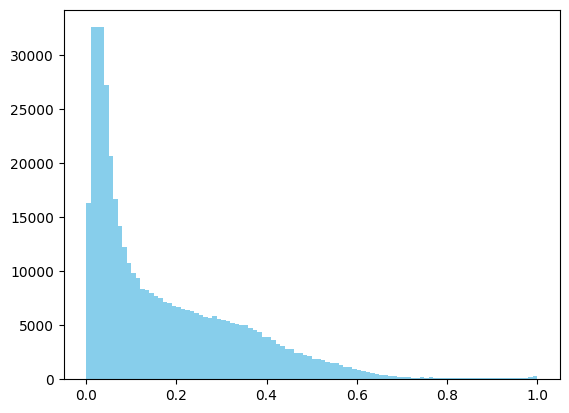

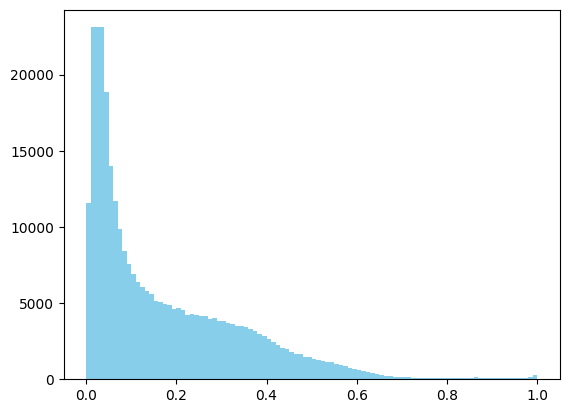

Balanced Train (458604, 9)
Balanced Test (318766, 9)


In [130]:
train_data = balance_dataset(train_data, True)
test_data = balance_dataset(test_data, True)
print("Balanced Train", train_data.shape)
print("Balanced Test", test_data.shape)

In [131]:
# Add in base data
with tf.device("cpu:0"):
    train_data = tf.concat([train_data, base_data], axis=0).numpy()
print("Train with base added", train_data.shape)

Train with base added (468952, 9)


In [132]:
# compute feature vector length
feature_len = 2 + int(3 * bones)

np.random.shuffle(train_data)
np.random.shuffle(test_data)
X_train = train_data[:, :feature_len]
y_train = train_data[:, feature_len:]

X_test = test_data[:, :feature_len]
y_test = test_data[:, feature_len:]

print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (468952, 8) (468952, 1)
Test: (318766, 8) (318766, 1)


In [133]:
def normalize(data):
    data = (data + np.pi/2) / np.pi
    return data

In [134]:
# normalize
X_train_min, X_train_max = np.min(X_train[:,2:]), np.max(X_train[:,2:])
X_test_min, X_test_max = np.min(X_test[:,2:]), np.max(X_test[:,2:])

X_train[:,2:] = normalize(X_train[:,2:])
X_test[:,2:] = normalize(X_test[:,2:])

print(f"Train: [{X_train_min}, {X_train_max}] -> [{np.min(X_train[:,2:])}, {np.max(X_train[:,2:])}]")
print(f"Test: [{X_test_min}, {X_test_max}] -> [{np.min(X_test[:,2:])}, {np.max(X_test[:,2:])}]")


Train: [-1.57075, 1.57075] -> [1.4746276810754354e-05, 0.9999852537231894]
Test: [-1.569109, 1.570566] -> [0.000537092800038356, 0.9999266847041314]


In [135]:
# ignore first joint -> 3 angles
with tf.device("cpu:0"):
    Xp_train = tf.concat([X_train[:,:2], X_train[:,5:]], axis=-1)
    Xp_test = tf.concat([X_test[:,:2], X_test[:,5:]], axis=-1)
feature_len -= 3
print("Train:", Xp_train.shape, y_train.shape)
print("Test:", Xp_test.shape, y_test.shape)

Train: (468952, 5) (468952, 1)
Test: (318766, 5) (318766, 1)


In [136]:
print(np.min(X_test[:,:2]), np.max(X_test[:,:2]))
print(np.min(Xp_test[:,:2]), np.max(Xp_test[:,:2]))

7e-06 0.999995
7e-06 0.999995


### Data Visualization

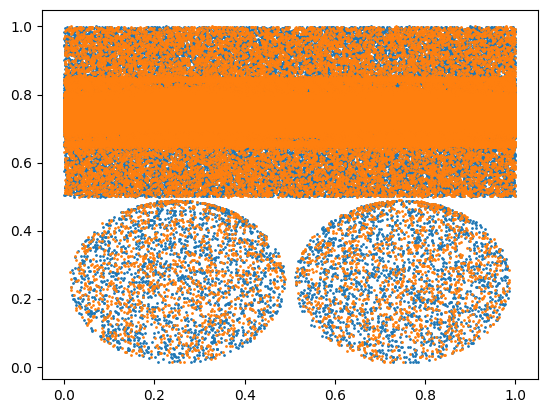

In [223]:
import matplotlib.pyplot as plt

plt.scatter(X_train[:,0], X_train[:,1], s=1)
plt.scatter(X_test[:,0], X_test[:,1], s=1)
plt.show()

### Encoding

### Build Model

<b>Inputs:</b> u, v, thetas
<br/><b>Output</b>: occlusion factor

In [9]:
# positional encoding
def positional_encoding(pos, output_dim):
    result = []
    for i in range(output_dim//2):
        result.append(tf.sin(2**i * pos))
        result.append(tf.cos(2**i * pos))
    return tf.concat(result, axis=-1)

def encode(data, enc_dim):
    enc = positional_encoding(data[:,:2], enc_dim) # u,v * 6
    with tf.device("cpu:0"):
        data = tf.concat([enc, data], axis=-1)
    return data

In [296]:
# encode
# enc_dim = 4
# Xp_train = encode(Xp_train, enc_dim)
# Xp_test = encode(Xp_test, enc_dim)
# feature_len = Xp_train.shape[1]
# print("Encoded", Xp_train.shape, Xp_test.shape)

Encoded (475192, 13) (330318, 13)


<b>Inputs:</b> thetas
<br/><b>Output</b>: occlusion factor for all vertices

In [120]:
# hidden_dim = 512
# inputs = keras.Input(shape=(feature_len,))
# x = keras.layers.Dense(hidden_dim, activation='relu')(inputs) # hidden
# x = keras.layers.Dense(hidden_dim, activation='relu')(x) # hidden
# x = keras.layers.Dense(hidden_dim, activation='relu')(x) # hidden
# x = keras.layers.Dense(hidden_dim, activation='relu')(x) # hidden
# x = keras.layers.BatchNormalization()(x)

# residual = keras.layers.Concatenate()([inputs, x])
# x = keras.layers.Dense(hidden_dim + feature_len, activation='relu')(residual) # hidden
# x = keras.layers.Dense(hidden_dim, activation='relu')(x) # hidden
# x = keras.layers.Dense(hidden_dim, activation='relu')(x) # hidden
# x = keras.layers.Dense(hidden_dim, activation='relu')(x) # hidden
# x = keras.layers.BatchNormalization()(x)

# output = keras.layers.Dense(1, activation='relu')(x) # output

# model = keras.Model(inputs=inputs, outputs=output, name="dao")

# initial_learning_rate = 0.001
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=10000,
#     decay_rate=0.95,
#     staircase=True)

# model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), loss=keras.losses.MeanSquaredError())

In [137]:
model = keras.Sequential([
    keras.Input(shape=(5,)),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(1, activation='relu')
])
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.MeanSquaredError())

What worked: 4 layers 256 nodes, relu. 3 * joints -> vertices ao

### Set up Tensorboard

In [39]:
%load_ext tensorboard
import datetime

### Train Model

In [138]:
# train model
log_dir = "logs_research/model_v4_3layer_relu/"
checkpoint_dir = "networks/research_model_v4.keras"

tensorboard_callback = tf.keras.callbacks.TensorBoard(
  log_dir=log_dir,
  histogram_freq=1
)
checkpoint_callback = keras.callbacks.ModelCheckpoint(
  filepath=checkpoint_dir,
  monitor='val_loss',
  mode='min',
  save_best_only=True
)

model.fit(x=Xp_train, 
          y=y_train, 
          epochs=200,
          batch_size=32,
          validation_data=(Xp_test, y_test), 
          callbacks=[tensorboard_callback, checkpoint_callback])

Epoch 1/200
14655/14655 [==============================] - 101s 7ms/step - loss: 0.0146 - val_loss: 0.0077
Epoch 2/200
14655/14655 [==============================] - 100s 7ms/step - loss: 0.0069 - val_loss: 0.0055
Epoch 3/200
14655/14655 [==============================] - 98s 7ms/step - loss: 0.0061 - val_loss: 0.0047
Epoch 4/200
14655/14655 [==============================] - 99s 7ms/step - loss: 0.0057 - val_loss: 0.0046
Epoch 5/200
14655/14655 [==============================] - 100s 7ms/step - loss: 0.0054 - val_loss: 0.0038
Epoch 6/200
14655/14655 [==============================] - 99s 7ms/step - loss: 0.0052 - val_loss: 0.0038
Epoch 7/200
14655/14655 [==============================] - 99s 7ms/step - loss: 0.0049 - val_loss: 0.0042
Epoch 8/200
14655/14655 [==============================] - 100s 7ms/step - loss: 0.0048 - val_loss: 0.0039
Epoch 9/200
14655/14655 [==============================] - 95s 6ms/step - loss: 0.0047 - val_loss: 0.0041
Epoch 10/200
14655/14655 [================

KeyboardInterrupt: 

To beat: 0.0022

### Output Texture

In [147]:
tex_input = []
# TODO: CENTER COORDS - doesn't really help
resolution = 256
joint_angle = normalize(np.array([0, 0, 0]))
theta = np.zeros((resolution*resolution, 3)) # bones * 3
for i in range(len(joint_angle)):
    theta[:,i] = np.full((resolution*resolution,), joint_angle[i])

uv = []
for j in range(resolution):
    for i in range(resolution):
        uv.append([i/resolution, 1.0-j/resolution])
uv = np.array(uv)
with tf.device("cpu:0"):
    tex_input = tf.concat([uv, theta], axis=-1)

tex_input = encode(tex_input, 4)
print(tex_input.shape)

(65536, 13)


In [148]:
loaded_model = keras.models.load_model("networks/research_model_v3.keras")
out = loaded_model.predict(tex_input)

2048/2048 [==============================] - 5s 2ms/step


(256, 256, 1)


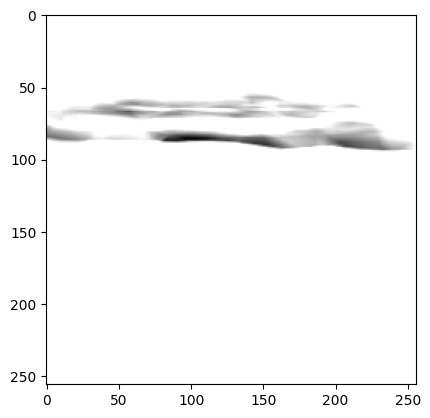

In [149]:
img = np.reshape(1.0-out, (resolution,resolution,1))
print(img.shape)
plt.imshow(img, cmap='gray')
plt.savefig('renders/research_model_v3_0_0_0.png', bbox_inches='tight') # 4 min generation

UV fitting: ~6e-3 after 100-140 epochs (maria_base.keras)<br/>
UV fitting w/ tpose: ~1e-4 after 150 epochs (maria_delta_base.keras)<br/>
Things to test:
* Batch norm
* Learning rate adjustment
* Layer width/depth
* Play with embedding dim

In [23]:
%tensorboard --logdir logs/maria_base

UsageError: Line magic function `%tensorboard` not found.


### UV Data

### Test Accuracy

In [ ]:
results = model.evaluate(X_test, y_test, batch_size=16)
print("test loss, test acc:", results)

2/2 [==============================] - 0s 6ms/step - loss: 0.0280 - mse: 0.0280
test loss, test acc: [0.028007308021187782, 0.028007308021187782]


### Get Model

In [ ]:
wab = model.get_weights()

In [ ]:
# manual evaluation 2 hidden layers: input = [u, v, theta]
# def manual_eval(input):
#     w1 = wab[0]
#     b1 = wab[1]
#     w2 = wab[2]
#     b2 = wab[3]
#     w3 = wab[4]
#     b3 = wab[5]

#     z1 = keras.activations.tanh(np.matmul(np.array(input), w1) + b1)
#     z2 = keras.activations.tanh(np.matmul(z1, w2) + b2)
#     z3 = keras.activations.tanh(np.matmul(z2, w3) + b3)
#     return z3.numpy()[0]

### Save to output file

In [ ]:
# save weights and biases as buffer
output_buf = str(len(model.layers)) + "\n" # layer count

for i in range(0, len(wab)-1, 2): # iterate through layers
    weights = wab[i]
    output_buf += str(weights.shape[0]) + " " + str(weights.shape[1]) + "\n" # input size output size
    for neuron in weights: # iterate through
        for edges in neuron:
            output_buf += str(edges) + " "
    for biases in wab[i+1]:
        output_buf += str(biases) + " "
    output_buf = output_buf[:-1] + "\n" # ignore extraneous space and end line
    

In [ ]:
with open("../resources/evaluators/model.txt", "w") as text_file:
    text_file.write(output_buf) # add more digits